In [1]:
# load packages
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as ss

from enigmatoolbox.utils.parcellation import parcel_to_surface
from enigmatoolbox.plotting import plot_cortical, plot_subcortical
from enigmatoolbox.utils.useful import reorder_sctx


ext_scripts_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/braincharts/scripts')
os.chdir(ext_scripts_dir)

from nm_utils import remove_bad_subjects, load_2d

code_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/code')
os.chdir(code_dir)

# importing custom functions
import clinics_desc_functions as custom

sns.set(rc={'figure.facecolor':'white'})


# formatiing
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

# discrete colorscale for heatmap
# colorscale
pk = sns.color_palette("RdBu_r", 8)
dcsc = sns.color_palette("RdBu_r", 8)
dcsc[0] = pk[3]
dcsc[1] = pk[2]
dcsc[2] = pk[1]
dcsc[3] = pk[0]
dcsc[4] = pk[7]
dcsc[5] = pk[6]
dcsc[6] = pk[5]
dcsc[7] = pk[4]


In [2]:
import prepare_models_for_analysis

model_name, site_names, site_ids_tr, idp_ids = custom.pretrained_ini()

# where things are
main_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO')
models_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/models/zscores_comparison_long')
os.makedirs(models_dir, exist_ok=True)
controls_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/models/control_stability_long')
patients_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/models/pretrained_long')
cdata_dir = ('/home/barbora/Documents/Projects/2021_06_AZV_ESO/data')
fsdata_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/fs_stats')
bdata_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/backup/fit_external_long')
pretrained_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/braincharts')
analysis_dir = os.path.join(main_dir, 'analyses', '01_PANSS')
images_dir = os.path.join(analysis_dir,'img')
os.makedirs(images_dir, exist_ok=True)


In [3]:
# load the data (generate them, if they don't exist)

if os.path.exists(os.path.join(analysis_dir,'data','pat_diff.txt')):
    v1_cont = pd.read_csv(os.path.join(analysis_dir,'data','v1_cont.txt'), sep=' ', index_col=0)
    v2_cont = pd.read_csv(os.path.join(analysis_dir,'data','v2_cont.txt'), sep=' ', index_col=0)
    v1_pat = pd.read_csv(os.path.join(analysis_dir,'data','v1_pat.txt'), sep=' ', index_col=0)
    v2_pat = pd.read_csv(os.path.join(analysis_dir,'data','v2_pat.txt'), sep=' ', index_col=0)
else:
    prepare_models_for_analysis.prepare_models_for_analysis(patients_dir, controls_dir, os.path.join(analysis_dir, 'data'))
    v1_cont = pd.read_csv(os.path.join(analysis_dir,'data','v1_cont.txt'), sep=' ', index_col=0)
    v2_cont = pd.read_csv(os.path.join(analysis_dir,'data','v2_cont.txt'), sep=' ', index_col=0)
    v1_pat = pd.read_csv(os.path.join(analysis_dir,'data','v1_pat.txt'), sep=' ', index_col=0)
    v2_pat = pd.read_csv(os.path.join(analysis_dir,'data','v2_pat.txt'), sep=' ', index_col=0)

In [4]:
# identify rows with missing clinical variables
clin_id = [i for i in v1_pat.columns if ('PANSS' in i) or ('GAF' in i)]

missing1 = list(dict.fromkeys(np.where(np.isnan(v1_pat[clin_id]))[0]))
missing2 = list(dict.fromkeys(np.where(np.isnan(v2_pat[clin_id]))[0]))
missing1.extend(missing2)
missing = list(dict.fromkeys(missing1))

In [5]:
# drop the rows
v1_pat = v1_pat.drop(v1_pat.iloc[missing].index)
v2_pat = v2_pat.drop(v2_pat.iloc[missing].index)
print(str(len(missing)),' patients were deleted')

3  patients were deleted


**1D analysis**
---------------

In [12]:
clin_id = [i for i in v1_pat if ('PANSS' in i) | ('GAF' in i) ]
clin_id.append("GAF")

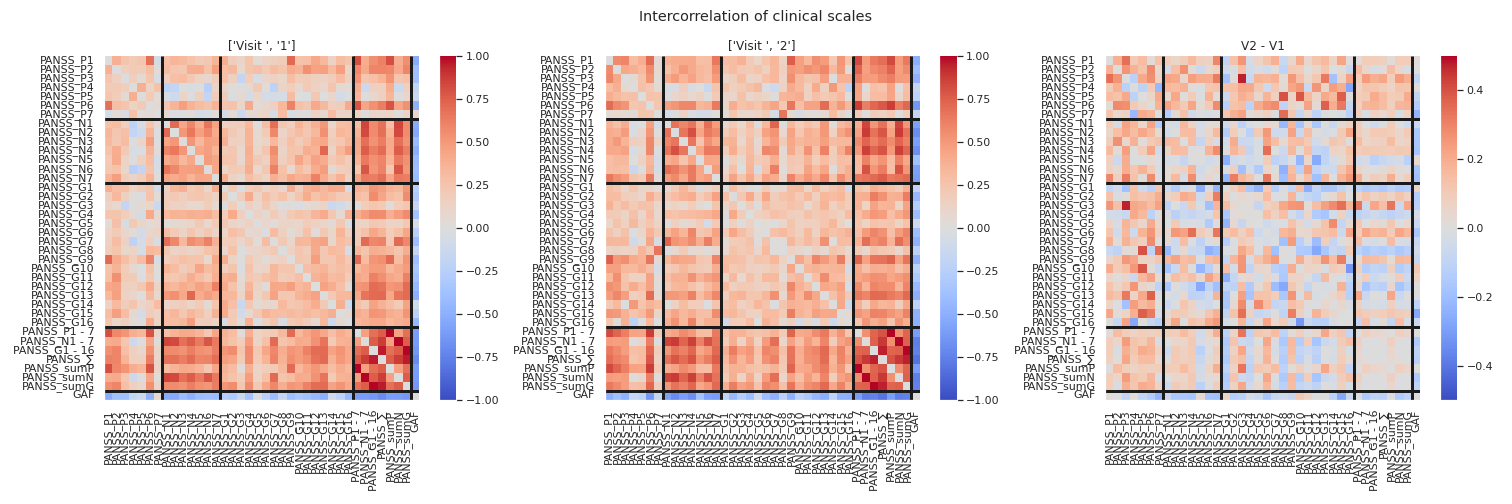

In [13]:
# Plot correlation matrices of clinical scales
import scipy.stats as ss 

fig,ax  = plt.subplots(1,3, figsize=(21,7))
for i in range(1,3):
    if i == 1:
        cmat = v1_pat
    else:
        cmat = v2_pat

    PANSS_spearman = ss.spearmanr(cmat[clin_id])

    sns.set(font_scale = 1)
    sns.heatmap(PANSS_spearman[0]-np.eye(PANSS_spearman[0].shape[0]), 
                center=False, 
                vmin = -1, 
                vmax = 1, 
                cmap='coolwarm', 
                annot=False,
                xticklabels=clin_id, yticklabels=clin_id,
                ax=ax[i-1])
    ax[i-1].hlines([7,14,PANSS_spearman[0].shape[0]-8, PANSS_spearman[0].shape[0]-1], *ax[i-1].get_xlim(), lw=3, color='k')
    ax[i-1].vlines([7,14,PANSS_spearman[0].shape[0]-8, PANSS_spearman[0].shape[0]-1], *ax[i-1].get_xlim(), lw=3, color='k')
    ax[i-1].set_title(['Visit ', str(i)])
    sns.despine()
    plt.tight_layout()
    plt.show

diff = ss.spearmanr(v2_pat[clin_id])[0] - ss.spearmanr(v1_pat[clin_id])[0]
sns.heatmap(diff, 
                center=False, 
                vmin = -.5, 
                vmax = .5, 
                cmap='coolwarm', 
                annot=False,
                xticklabels=clin_id, yticklabels=clin_id,
                ax=ax[2])
ax[2].set_title('V2 - V1')
ax[2].hlines([7,14,PANSS_spearman[0].shape[0]-8, PANSS_spearman[0].shape[0]-1], *ax[2].get_xlim(), lw=3, color='k')
ax[2].vlines([7,14,PANSS_spearman[0].shape[0]-8, PANSS_spearman[0].shape[0]-1], *ax[2].get_xlim(), lw=3, color='k')
fig.suptitle('Intercorrelation of clinical scales')
sns.despine()
plt.tight_layout()
plt.show
plt.savefig(os.path.join(images_dir,'clinics_intercorrelation'))




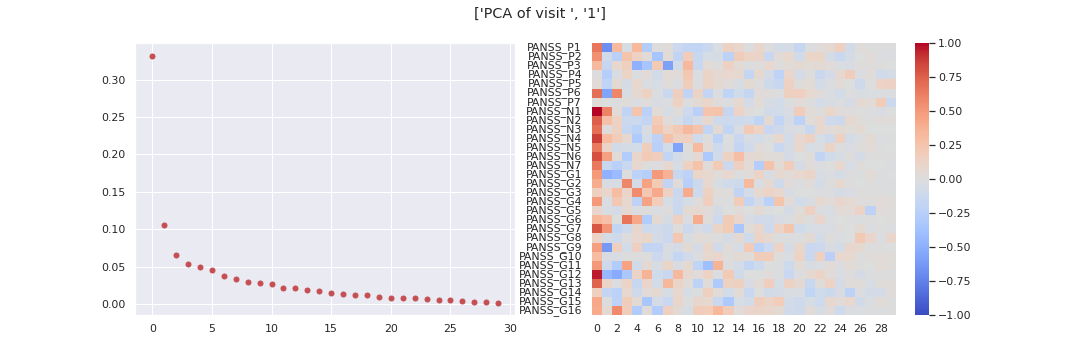

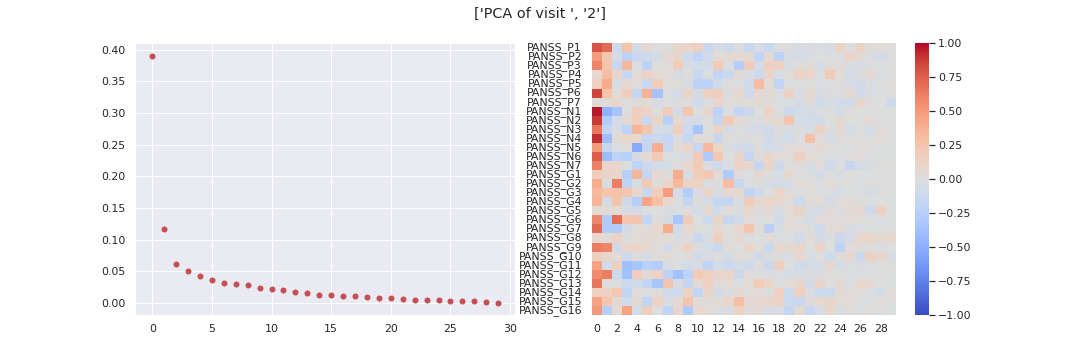

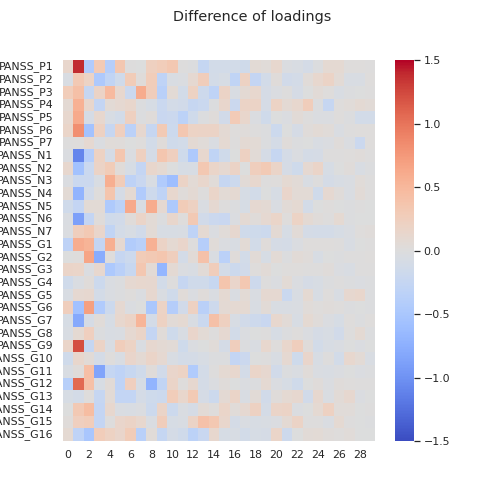

In [14]:
# PCA od PANSS scores
from sklearn.decomposition import PCA
for i in range(1,3):
    if i ==1:
        pcamat = v1_pat
    else:
        pcamat = v2_pat

    pca = PCA(n_components=min(pcamat[clin_id[:-8]].shape))
    pca.fit(pcamat[clin_id[:-8]])

    fig,ax  = plt.subplots(1,2, figsize=(15,5))
    ax[0].plot(range(len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_, 'ro', markersize=5, linewidth = 3)
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    sns.heatmap(loadings, yticklabels=clin_id[:-8], ax=ax[1], vmin=-1,vmax=1, cmap='coolwarm')
    fig.suptitle(['PCA of visit ', str(i)])
    plt.savefig(os.path.join(images_dir,'pca_PANSS_v'+str(i)))

pca1 = PCA(n_components=min(pcamat[clin_id[:-8]].shape))
pca1.fit(v1_pat[clin_id[:-8]])
pca2 = PCA(n_components=min(pcamat[clin_id[:-8]].shape))
pca2.fit(v2_pat[clin_id[:-8]])

fig,ax  = plt.subplots(1,1, figsize=(7,7))
sns.heatmap((pca2.components_.T * np.sqrt(pca2.explained_variance_) - pca1.components_.T * np.sqrt(pca1.explained_variance_)), yticklabels=clin_id[:-8], cmap='coolwarm', vmin=-1.5, vmax=1.5)
fig.suptitle('Difference of loadings')
plt.savefig(os.path.join(images_dir,'pca_PANSS_v2-v1'))

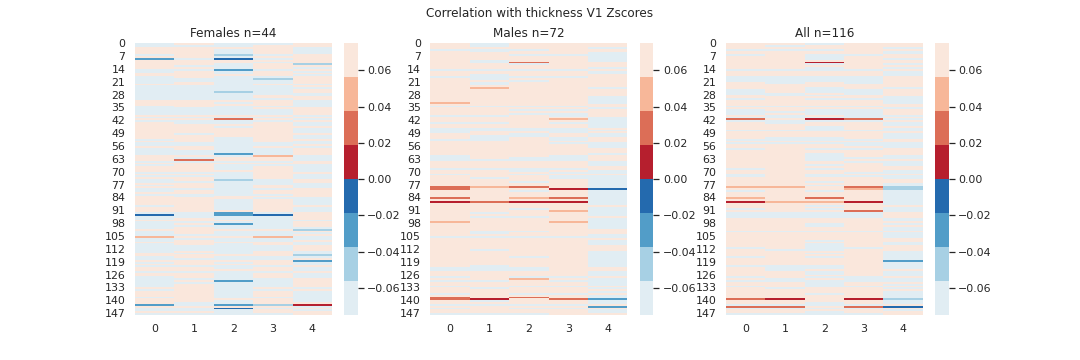

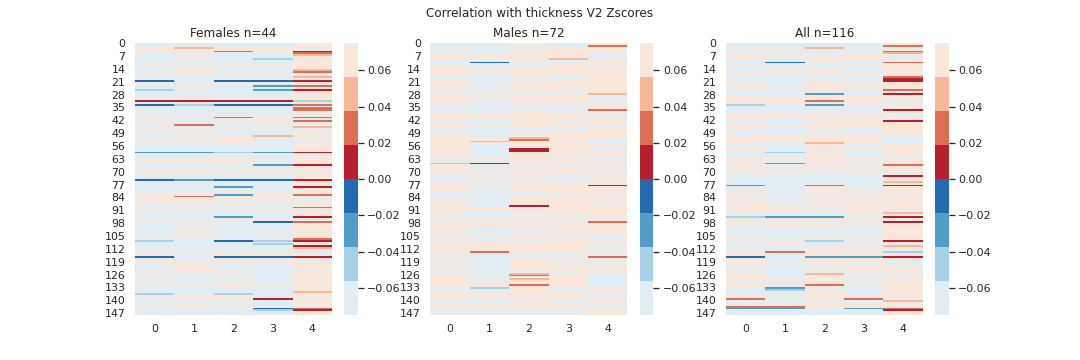

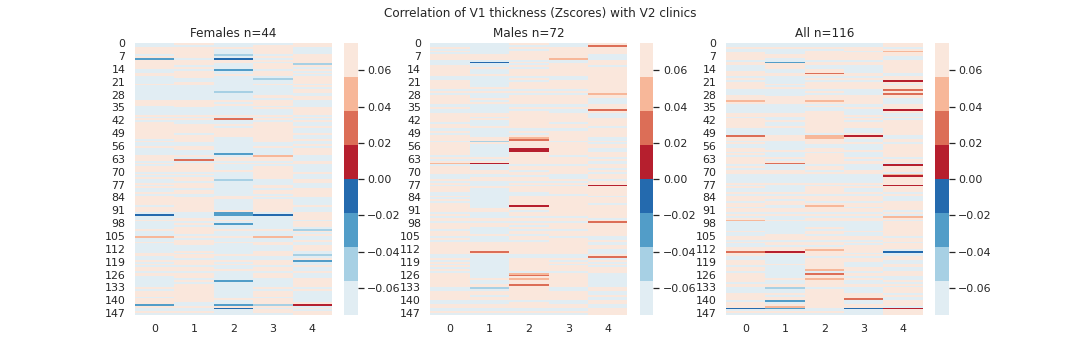

In [30]:
# Using lienar regression model
###
import pingouin as pg

thick_id = [i for i in v1_pat.columns if 'thickness' in i]
clin_id = [i for i in v1_pat.columns if ('PANSS' in i) or ('GAF' in i)]

f = v1_pat.index[v1_pat['sex']==0]
m = v1_pat.index[v1_pat['sex']==1]

for i in range(1,4):

    coef_f = np.empty([len(thick_id), len(clin_id[33:])])
    p_f = np.empty([len(thick_id), len(clin_id[33:])])

    coef_m = np.empty([len(thick_id), len(clin_id[33:])])
    p_m = np.empty([len(thick_id), len(clin_id[33:])])

    coef_a = np.empty([len(thick_id), len(clin_id[33:])])
    p_a = np.empty([len(thick_id), len(clin_id[33:])])

    if i==1:
        cmat1 = v1_pat
        cmat2 = v1_pat
    elif i ==2:
        cmat1 = v2_pat
        cmat2 = v2_pat
    elif i ==3:
        cmat1 = v1_pat
        cmat2 = v2_pat

    for iroi, roi in enumerate(thick_id):
        for iclin, clin in enumerate(clin_id[33:]):
            tempf = pg.linear_regression(cmat1[['age', roi]].loc[f], cmat1[clin].loc[f])
            tempm = pg.linear_regression(cmat2[['age', roi]].loc[m], cmat2[clin].loc[m])
            tempa = pg.linear_regression(cmat1[['age', 'sex', roi]], cmat2[clin])
            
            coef_f[iroi, iclin], p_f[iroi,iclin] = [tempf["coef"][2], tempf["pval"][2]]
            coef_m[iroi, iclin], p_m[iroi,iclin] = [tempm["coef"][2], tempm["pval"][2]]
            coef_a[iroi, iclin], p_a[iroi,iclin] = [tempa["coef"][3], tempa["pval"][3]]

    fig, ax = plt.subplots(1,3, figsize=(15,5))
    sns.heatmap(np.sign(coef_f)*p_f, cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[0])
    ax[0].set_title('Females n='+str(len(f)))
    sns.heatmap(np.sign(coef_m)*p_m, cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[1])
    ax[1].set_title('Males n='+str(len(m)))
    sns.heatmap(np.sign(coef_a)*p_a, cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[2])
    ax[2].set_title('All n='+str(len(f)+len(m)))
    if (i == 1) | (i==2):
        fig.suptitle('Correlation with thickness V'+str(i)+' Zscores')
        plt.savefig(os.path.join(images_dir, 'heatmaps_thickness_zscores_v'+str(i)))
    if (i == 3):
        fig.suptitle('Correlation of V1 thickness (Zscores) with V2 clinics')
        plt.savefig(os.path.join(images_dir, 'heatmaps_thickness_zscores_v1_clinics_v2'))

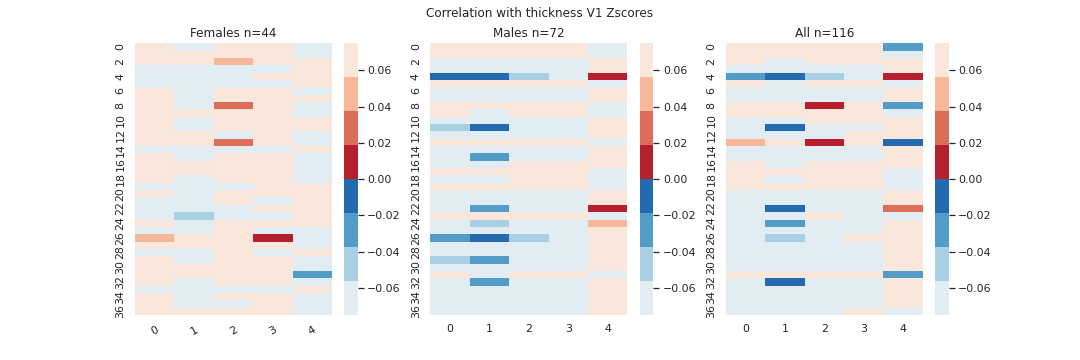

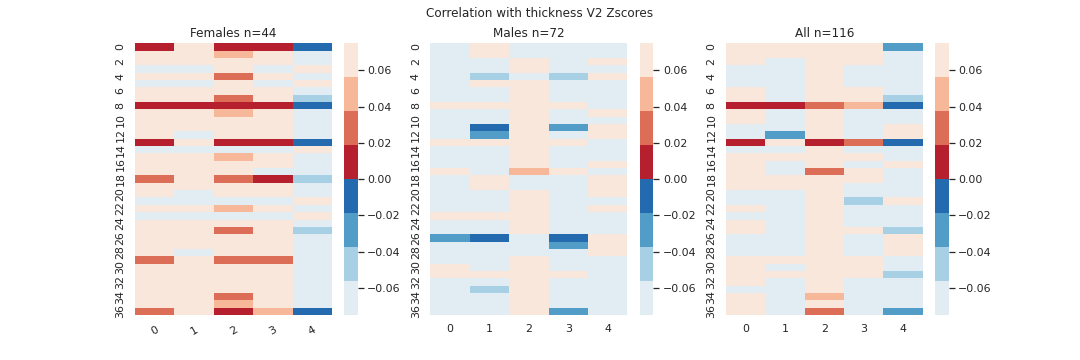

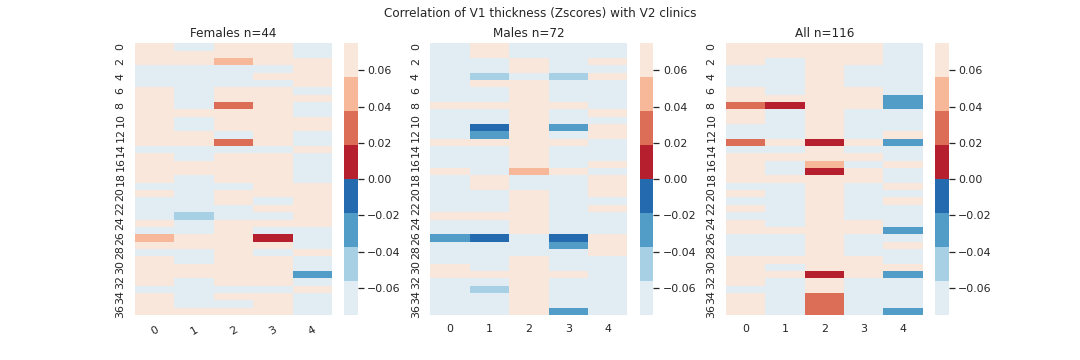

In [31]:
###
# Using lienar regression model
###
import pingouin as pg

sc_id = [i for i in idp_ids if 'thickness' not in i]

f = v1_pat.index[v1_pat['sex']==0]
m = v1_pat.index[v1_pat['sex']==1]

for i in range(1,4):

    coef_f = np.empty([len(sc_id), len(clin_id[33:])])
    p_f = np.empty([len(sc_id), len(clin_id[33:])])

    coef_m = np.empty([len(sc_id), len(clin_id[33:])])
    p_m = np.empty([len(sc_id), len(clin_id[33:])])

    coef_a = np.empty([len(sc_id), len(clin_id[33:])])
    p_a = np.empty([len(sc_id), len(clin_id[33:])])

    if i==1:
        cmat1 = v1_pat
        cmat2 = v1_pat
    elif i ==2:
        cmat1 = v2_pat
        cmat2 = v2_pat
    elif i ==3:
        cmat1 = v1_pat
        cmat2 = v2_pat

    for iroi, roi in enumerate(sc_id):
        for iclin, clin in enumerate(clin_id[33:]):
            tempf = pg.linear_regression(cmat1[['age', roi]].loc[f], cmat1[clin].loc[f])
            tempm = pg.linear_regression(cmat2[['age', roi]].loc[m], cmat2[clin].loc[m])
            tempa = pg.linear_regression(cmat1[['age', 'sex', roi]], cmat2[clin])
            
            coef_f[iroi, iclin], p_f[iroi,iclin] = [tempf["coef"][2], tempf["pval"][2]]
            coef_m[iroi, iclin], p_m[iroi,iclin] = [tempm["coef"][2], tempm["pval"][2]]
            coef_a[iroi, iclin], p_a[iroi,iclin] = [tempa["coef"][3], tempa["pval"][3]]

    fig, ax = plt.subplots(1,3, figsize=(15,5), sharex=True)
    sns.heatmap(np.sign(coef_f)*p_f, cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[0])
    ax[0].set_title('Females n='+str(len(f)))
    ax[0].set_xticklabels(clin_id[33:], rotation = 30)
    sns.heatmap(np.sign(coef_m)*p_m, cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[1])
    ax[1].set_title('Males n='+str(len(m)))
    sns.heatmap(np.sign(coef_a)*p_a, cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[2])
    ax[2].set_title('All n='+str(len(f)+len(m)))
    if (i == 1) | (i==2):
        fig.suptitle('Correlation with thickness V'+str(i)+' Zscores')
        plt.savefig(os.path.join(images_dir, 'heatmaps_volumes_zscores_v'+str(i)))
    if (i == 3):
        fig.suptitle('Correlation of V1 thickness (Zscores) with V2 clinics')
        plt.savefig(os.path.join(images_dir, 'heatmaps_volumes_zscores_v1_clinics_v2'))

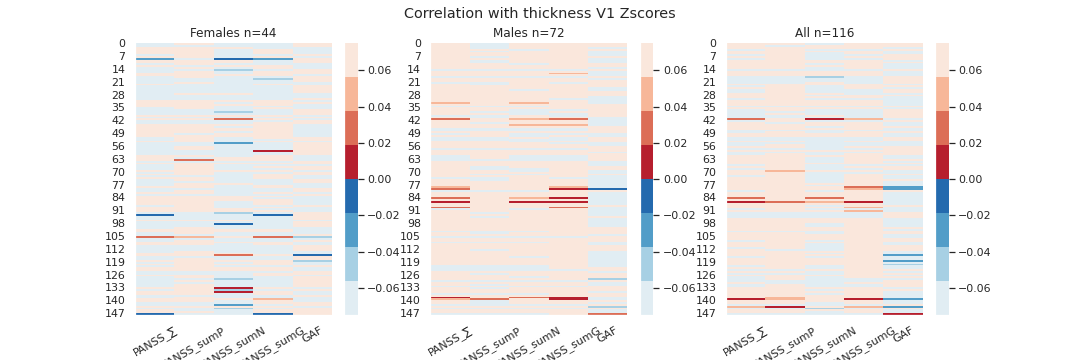

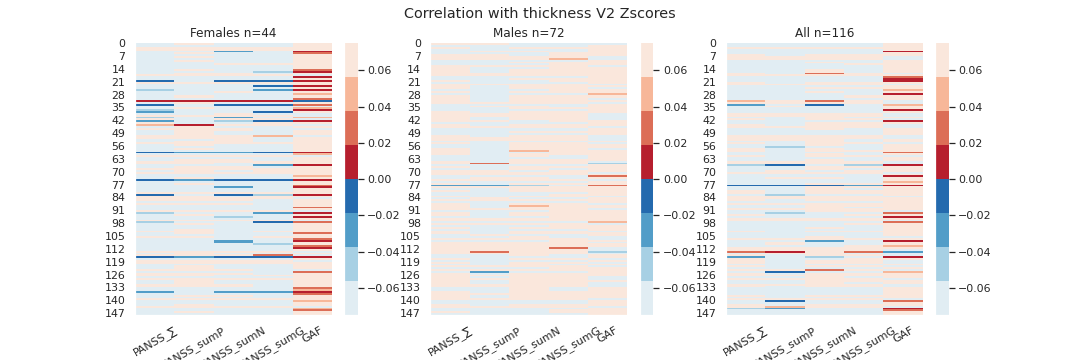

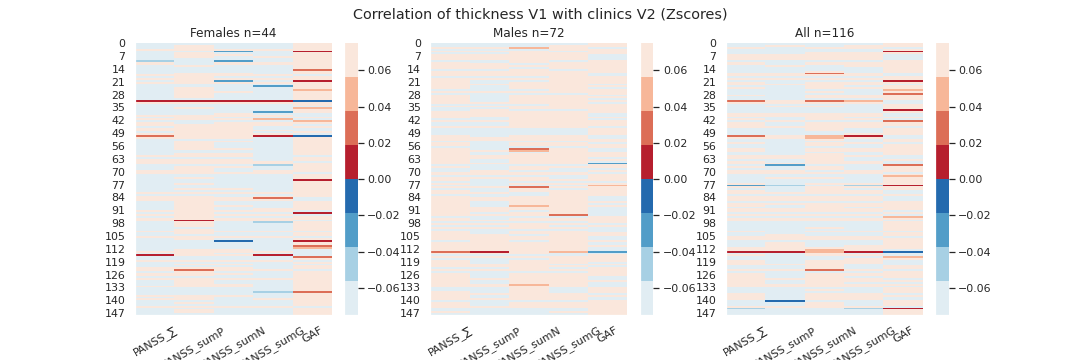

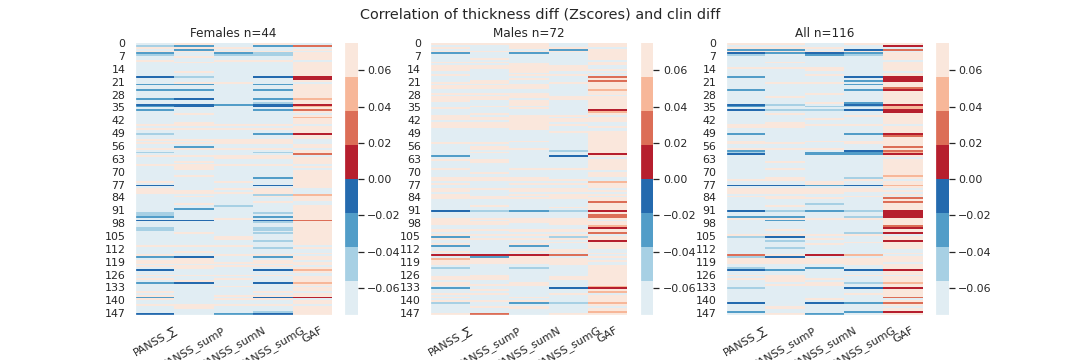

In [387]:
# Do NOT use - this is the alternative with spearman correlation - use Linear Regression instead
### 
# Compute correlation of thickness zscores with clinical scales across sex
###

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

thick_id = [i for i in v1_pat.columns if 'thickness' in i]
f = v1_pat.index[v1_pat['sex']==0]
m = v1_pat.index[v1_pat['sex']==1]

for i in range(1,5):
    if i==1:
        cmat1 = v1_pat
        cmat2 = v1_pat
    elif i==2:
        cmat1 = v2_pat
        cmat2 = v2_pat
    elif i==3:
        cmat1 = v1_pat
        cmat2 = v2_pat
    elif i==4:
        cmat1 = v2_pat[thick_id]-v1_pat[thick_id]
        cmat2 = pd.merge(pd.DataFrame(v2_pat[clin_id].to_numpy()-v1_pat[clin_id].to_numpy(), index=v1_pat.index, columns=clin_id), v1_pat[["age","sex"]], left_index=True, right_index=True)

    clin_cont_f = custom.control_for(cmat2[clin_id[33:]].loc[f].to_numpy(), cmat2["age"].loc[f].to_numpy()[:,np.newaxis])
    clin_cont_m = custom.control_for(cmat2[clin_id[33:]].loc[m].to_numpy(), cmat2["age"].loc[m].to_numpy()[:,np.newaxis])
    clin_cont_a = custom.control_for(cmat2[clin_id[33:]].to_numpy(), cmat2[["age","sex"]].to_numpy())

    spearman_f = custom.spearman_matrices(cmat1[thick_id].loc[f], clin_cont_f)
    spearman_m = custom.spearman_matrices(cmat1[thick_id].loc[m], clin_cont_m)
    spearman_all = custom.spearman_matrices(cmat1[thick_id], clin_cont_a)

    fig, ax = plt.subplots(1,3, figsize=(15,5))
    sns.heatmap(spearman_f[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[0])
    ax[0].set_title('Females n='+str(len(f)))
    ax[0].set_xticklabels(clin_id[33:], rotation = 30)

    sns.heatmap(spearman_m[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[1])
    ax[1].set_title('Males n='+str(len(m)))
    ax[1].set_xticklabels(clin_id[33:], rotation = 30)

    sns.heatmap(spearman_all[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[2])
    ax[2].set_title('All n='+str(len(f)+len(m)))
    ax[2].set_xticklabels(clin_id[33:], rotation = 30)
    
    sns.despine()

    if (i==1) | (i==2):
        fig.suptitle('Correlation with thickness V'+str(i)+' Zscores')
        #plt.savefig(os.path.join(images_dir, 'PANSS_correct_heatmaps_thickness_zscore_v'+str(i)))
    elif i==3:
        fig.suptitle('Correlation of thickness V1 with clinics V2 (Zscores)')
        #plt.savefig(os.path.join(images_dir, 'PANSS_correct_heatmaps_thickness_zscore_v12'))
    elif i==4:
        fig.suptitle('Correlation of thickness diff (Zscores) and clin diff')
        #plt.savefig(os.path.join(images_dir, 'PANSS_correct_heatmaps_thickness_zscore_diff'))
    
    
    

ValueError: The number of FixedLocator locations (19), usually from a call to set_ticks, does not match the number of ticklabels (37).

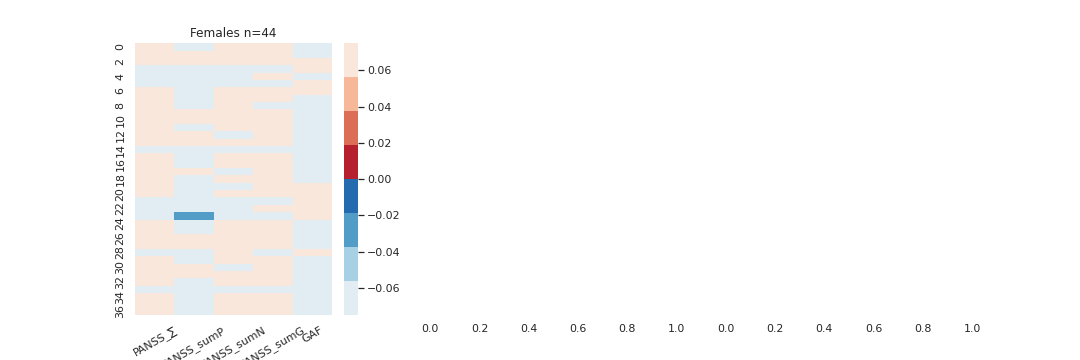

In [394]:
# DO NOT USE - this is the alternative with spearman correlation - use Linear Regression instead...
        cmat2 = v1_pat
    elif i==2:
        cmat1 = v2_pat
        cmat2 = v2_pat
    elif i==3:
        cmat1 = v1_pat
        cmat2 = v2_pat
    elif i==4:
        cmat1 = v2_pat[sc_id]-v1_pat[sc_id]
        cmat2 = pd.merge(pd.DataFrame(v2_pat[clin_id].to_numpy()-v1_pat[clin_id].to_numpy(), index=v1_pat.index, columns=clin_id), v1_pat[["age","sex"]], left_index=True, right_index=True)

    clin_cont_f = custom.control_for(cmat2[clin_id[33:]].loc[f].to_numpy(), cmat2["age"].loc[f].to_numpy()[:,np.newaxis])
    clin_cont_m = custom.control_for(cmat2[clin_id[33:]].loc[m].to_numpy(), cmat2["age"].loc[m].to_numpy()[:,np.newaxis])
    clin_cont_a = custom.control_for(cmat2[clin_id[33:]].to_numpy(), cmat2[["age","sex"]].to_numpy())

    spearman_f = custom.spearman_matrices(cmat1[sc_id].loc[f], clin_cont_f)
    spearman_m = custom.spearman_matrices(cmat1[sc_id].loc[m], clin_cont_m)
    spearman_all = custom.spearman_matrices(cmat1[sc_id], clin_cont_a)

    fig, ax = plt.subplots(1,3, figsize=(15,5), sharey=True)
    sns.heatmap(spearman_f[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[0])
    ax[0].set_title('Females n='+str(len(f)))
    ax[0].set_xticklabels(clin_id[33:], rotation = 30)
    
    sns.heatmap(spearman_m[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[1])
    ax[1].set_title('Males n='+str(len(m)))
    ax[1].set_xticklabels(clin_id[33:], rotation = 30)

    sns.heatmap(spearman_all[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[2])
    ax[2].set_title('All n='+str(len(f)+len(m)))
    ax[2].set_xticklabels(clin_id[33:], rotation = 30)
    
    sns.despine()

    if (i==1) | (i==2):
        fig.suptitle('Correlation with thickness V'+str(i)+' Zscores')
        #plt.savefig(os.path.join(images_dir, 'PANSS_correct_heatmaps_volumes_zscore_v'+str(i)))
    elif i==3:
        fig.suptitle('Correlation of thickness V1 with clinics V2 (Zscores)')
        #plt.savefig(os.path.join(images_dir, 'PANSS_correct_heatmaps_volumes_zscore_v12'))
    elif i==4:
        fig.suptitle('Correlation of volumes diff (Zscores) and clin diff')
        #plt.savefig(os.path.join(images_dir, 'PANSS_correct_heatmaps_volumes_zscore_diff'))
    
    
    

Comparison with pure thickness and volume instead of scores
-----------------------------------------------------------------

In [27]:
v1_pat_raw = pd.read_csv(os.path.join(analysis_dir,'data','v1_pat_raw.txt'), sep=' ', index_col=0)
v2_pat_raw = pd.read_csv(os.path.join(analysis_dir,'data','v2_pat_raw.txt'), sep=' ', index_col=0)

v1_pat_raw = pd.concat([v1_pat_raw,v1_pat[clin_id]],axis=1,join='inner')
v2_pat_raw = pd.concat([v2_pat_raw,v2_pat[clin_id]],axis=1,join='inner')

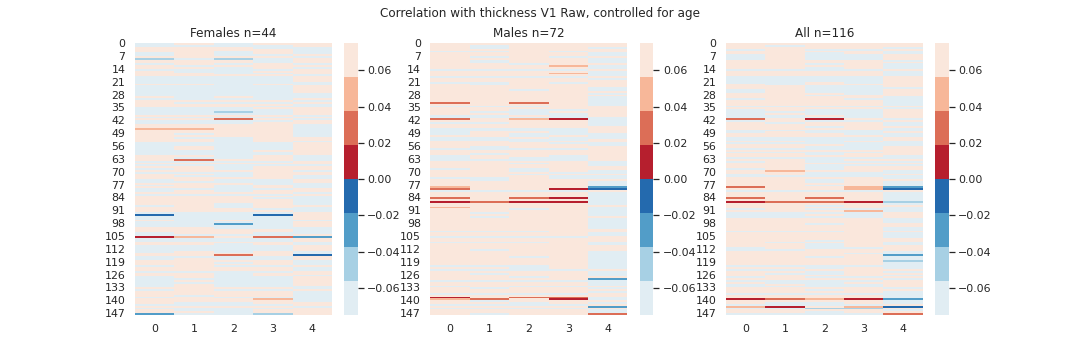

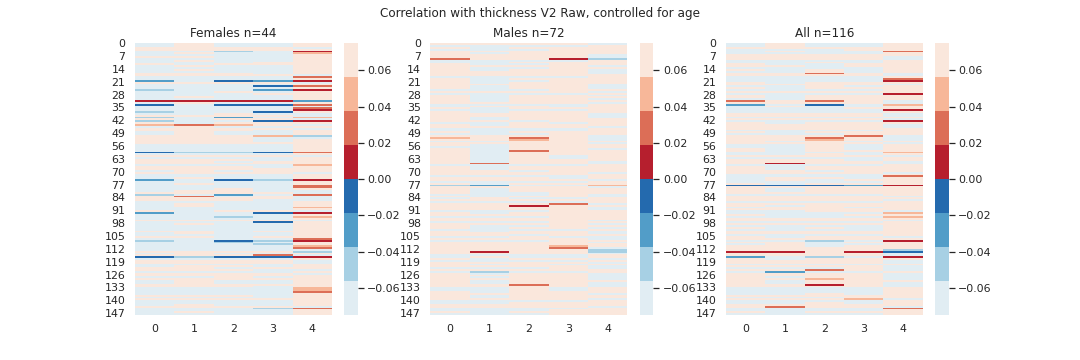

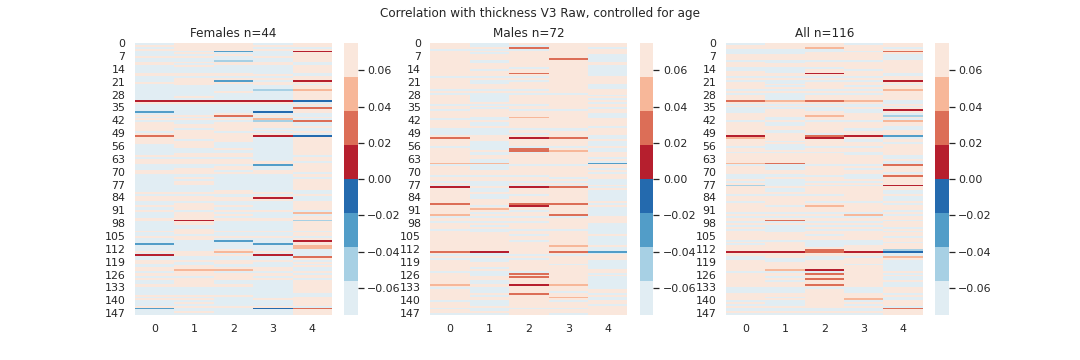

In [33]:
# Compute correlation of thickness with clinical scales across sex
thick_id = [i for i in v1_pat.columns if 'thickness' in i]
f = v1_pat_raw.index[v1_pat['sex']==0]
m = v1_pat_raw.index[v1_pat['sex']==1]

for i in range(1,4):
    if i==1:
        cmat1 = v1_pat_raw
        cmat2 = v1_pat_raw
    if i==2:
        cmat1 = v2_pat_raw
        cmat2 = v2_pat_raw
    if i==3:
        cmat1 = v1_pat_raw
        cmat2 = v2_pat_raw

    control_f = custom.control_for(cmat1[thick_id].loc[f].to_numpy(), cmat1['age'].loc[f].to_numpy().reshape(-1,1))
    control_fclin = custom.control_for(cmat2[clin_id].loc[f].to_numpy(), cmat2['age'].loc[f].to_numpy().reshape(-1,1))
    spearman_f = custom.spearman_matrices(control_f, control_fclin[:,33:])
    
    control_m = custom.control_for(cmat1[thick_id].loc[m].to_numpy(), cmat1['age'].loc[m].to_numpy().reshape(-1,1))
    control_mclin = custom.control_for(cmat2[clin_id].loc[m].to_numpy(), cmat2['age'].loc[m].to_numpy().reshape(-1,1))
    spearman_m = custom.spearman_matrices(control_m, control_mclin[:,33:])
    
    control_all = custom.control_for(cmat1[thick_id].to_numpy(), cmat1['age'].to_numpy().reshape(-1,1))
    control_aclin = custom.control_for(cmat2[clin_id].to_numpy(), cmat2['age'].to_numpy().reshape(-1,1))
    spearman_all = custom.spearman_matrices(control_all, control_aclin[:,33:])

    fig, ax = plt.subplots(1,3, figsize=(15,5))
    sns.heatmap(spearman_f[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[0])
    ax[0].set_title('Females n='+str(len(f)))
    sns.heatmap(spearman_m[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[1])
    ax[1].set_title('Males n='+str(len(m)))
    sns.heatmap(spearman_all[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[2])
    ax[2].set_title('All n='+str(len(f)+len(m)))
    if (i == 1) | (i==2):
        fig.suptitle('Correlation with thickness V'+str(i)+' Raw, controlled for age')
        plt.savefig(os.path.join(images_dir, 'heatmaps_thickness_raw_v'+str(i)))
    elif i==3:
        fig.suptitle('Correlation with thickness V'+str(i)+' Raw, controlled for age')
        plt.savefig(os.path.join(images_dir, 'heatmaps_thickness_raw_v1_clinics_v2'))




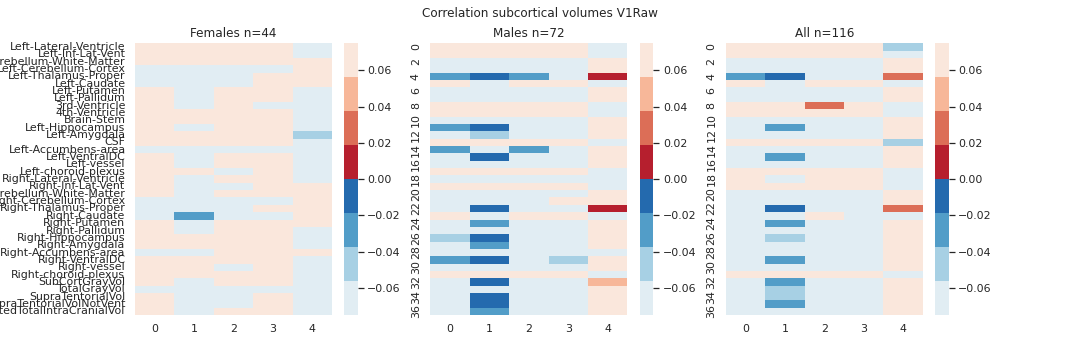

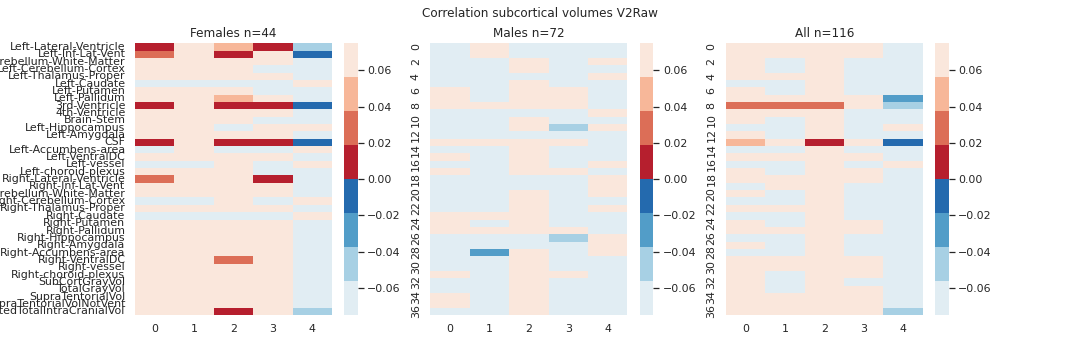

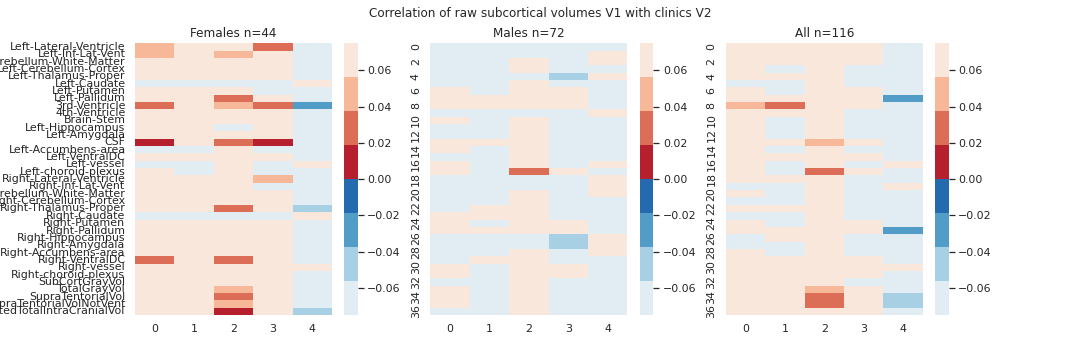

In [40]:
# Compute correlation of thickness with clinical scales across sex
sc_id = [i for i in idp_ids if 'thickness' not in i]
f = v1_pat_raw.index[v1_pat['sex']==0]
m = v1_pat_raw.index[v1_pat['sex']==1]

for i in range(1,4):
    if i==1:
        cmat1 = v1_pat_raw
        cmat2 = v1_pat_raw
    if i==2:
        cmat1 = v2_pat_raw
        cmat2 = v2_pat_raw
    if i==3:
        cmat1 = v1_pat_raw
        cmat2 = v2_pat_raw

    control_f = custom.control_for(cmat1[sc_id].loc[f].to_numpy(), cmat1['age'].loc[f].to_numpy().reshape(-1,1))
    control_fclin = custom.control_for(cmat2[clin_id].loc[f].to_numpy(), cmat2['age'].loc[f].to_numpy().reshape(-1,1))
    spearman_f = custom.spearman_matrices(control_f, control_fclin[:,33:])
    
    control_m = custom.control_for(cmat1[sc_id].loc[m].to_numpy(), cmat1['age'].loc[m].to_numpy().reshape(-1,1))
    control_mclin = custom.control_for(cmat2[clin_id].loc[m].to_numpy(), cmat2['age'].loc[m].to_numpy().reshape(-1,1))
    spearman_m = custom.spearman_matrices(control_m, control_mclin[:,33:])
    
    control_a = custom.control_for(cmat1[sc_id].to_numpy(), cmat1['age'].to_numpy().reshape(-1,1))
    control_aclin = custom.control_for(cmat2[clin_id].to_numpy(), cmat2['age'].to_numpy().reshape(-1,1))
    spearman_all = custom.spearman_matrices(control_a, control_aclin[:,33:])

    fig, ax = plt.subplots(1,3, figsize=(15,5))
    sns.heatmap(spearman_f[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[0], yticklabels=sc_id)
    ax[0].set_title('Females n='+str(len(f)))
    sns.heatmap(spearman_m[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[1])
    ax[1].set_title('Males n='+str(len(m)))
    sns.heatmap(spearman_all[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[2])
    ax[2].set_title('All n='+str(len(f)+len(m)))

    if (i==1) | (i==2):
        fig.suptitle('Correlation subcortical volumes V'+str(i)+'Raw')
        plt.savefig(os.path.join(images_dir, 'heatmaps_sc_volumes_raw_v'+str(i)))
    elif i==3:
        fig.suptitle('Correlation of raw subcortical volumes V1 with clinics V2')
        plt.savefig(os.path.join(images_dir, 'heatmaps_sc_volumes_raw_v1_clin_v2'))

**Basic analysis with PCA**
----------------------------

In [125]:
from sklearn.decomposition import PCA

thick_id = [i for i in idp_ids if 'thickness' in i] 
sc_id = [i for i in idp_ids if 'thickness' not in i]
clin_id = [i for i in v1_pat if ('PANSS' in i) | ('GAF' in i) ]
f = v1_pat.index[v1_pat['sex']==0]
m = v1_pat.index[v1_pat['sex']==1]

f_id = [np.where(v1_pat.index == i)[0][0] for i in f]
m_id = [np.where(v1_pat.index == i)[0][0] for i in m]


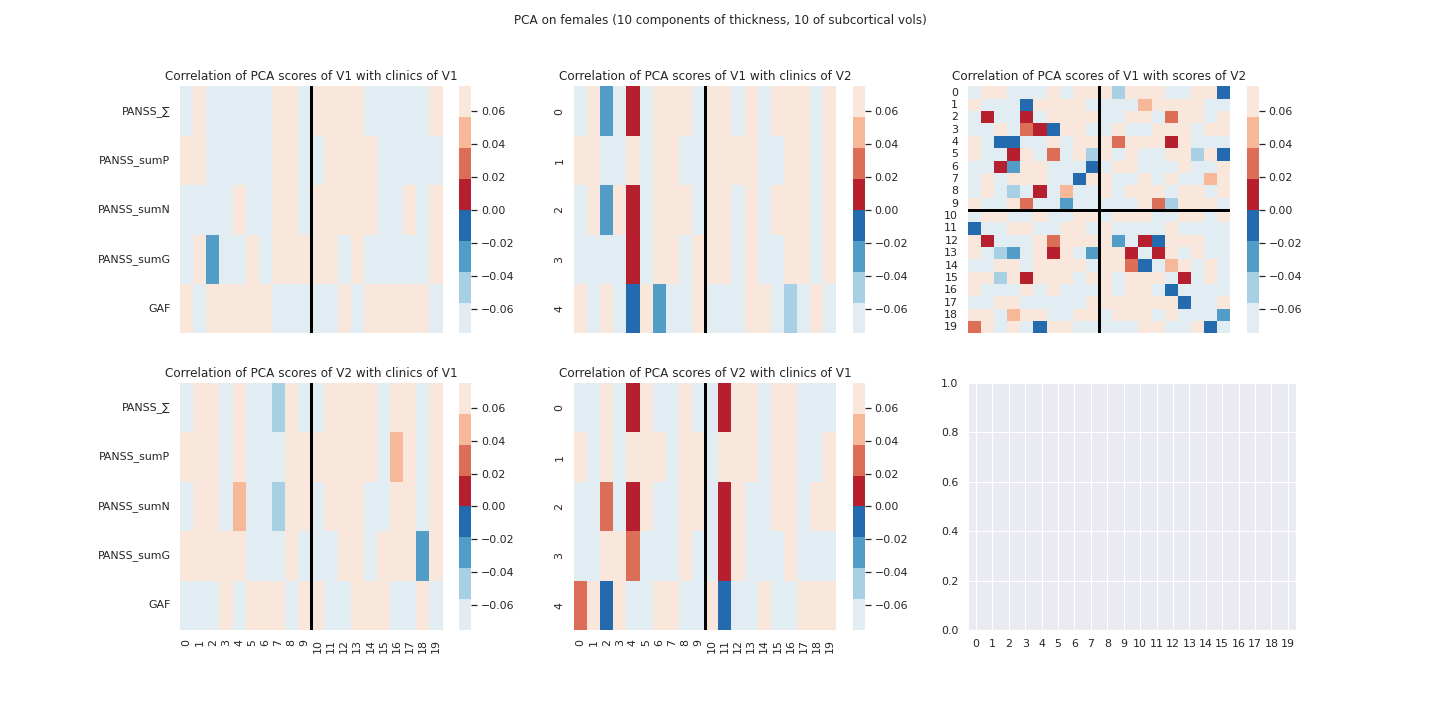

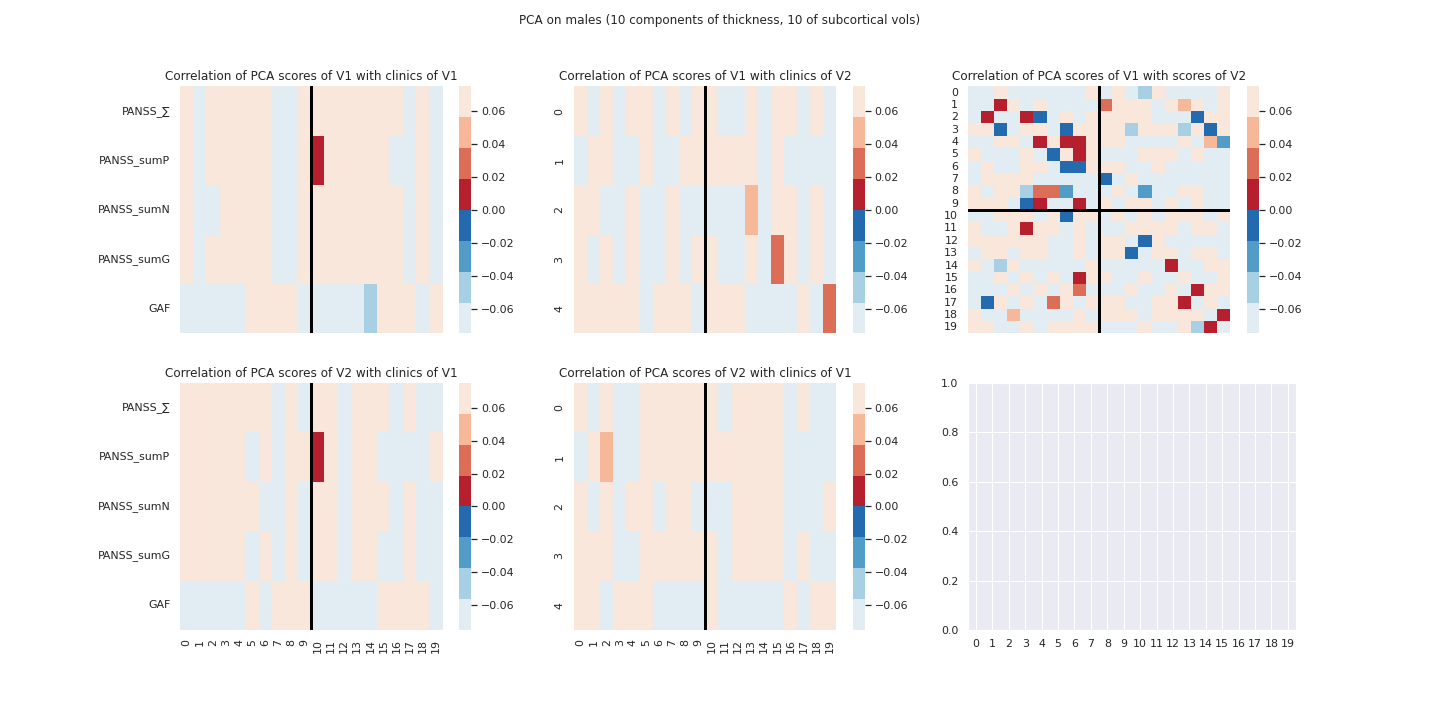

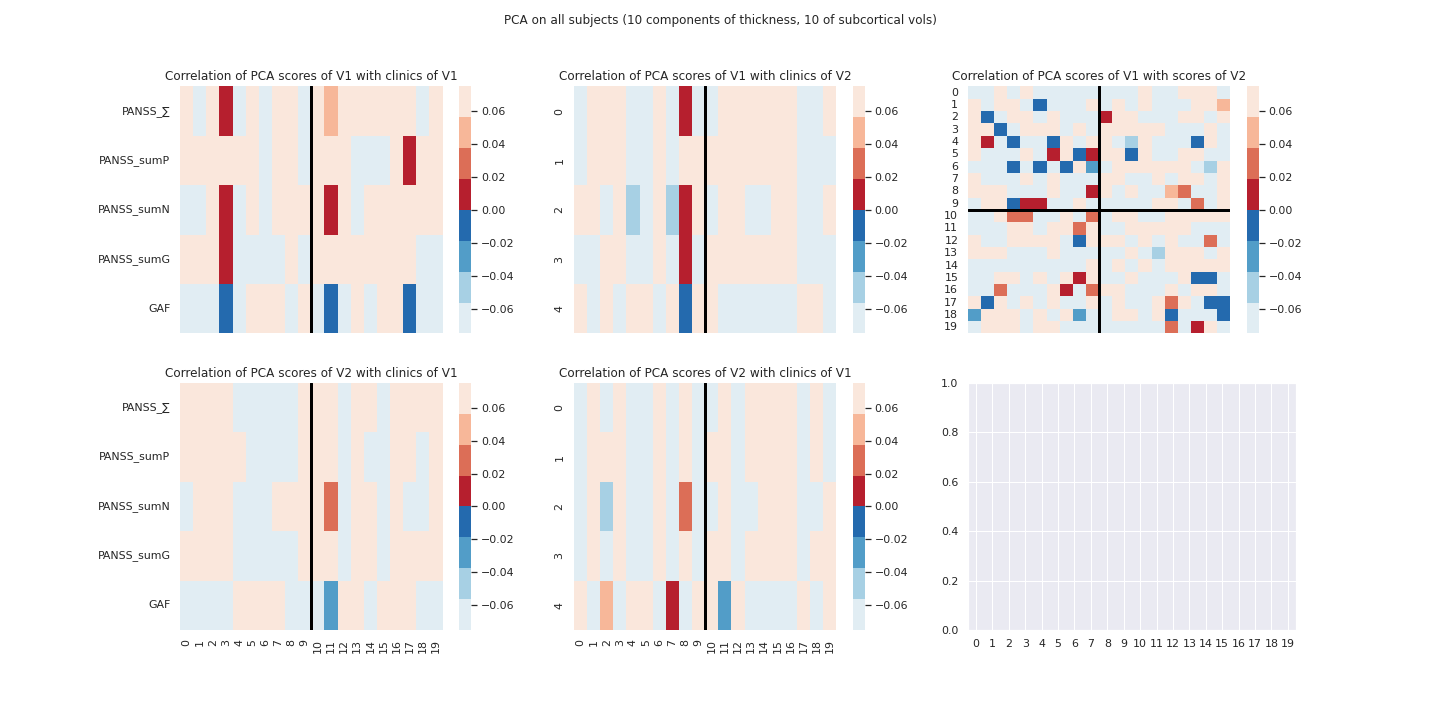

In [141]:
# Compute PCA across sexes and visits and plot the results

for i in range(3):
    if i == 0:
        pcamat1 = v1_pat[v1_pat['sex'] == 0]
        pcamat2 = v2_pat[v1_pat['sex'] == 0]        
    elif i == 1:
        pcamat1 = v1_pat[v1_pat['sex'] == 1]
        pcamat2 = v2_pat[v1_pat['sex'] == 1]
    elif i == 2:
        pcamat1 = v1_pat
        pcamat2 = v2_pat


    v1_pca_thick = PCA(n_components=min(pcamat1[thick_id].shape))
    v1_pca_thick.fit(pcamat1[thick_id])
    loadings_thick = v1_pca_thick.components_.T * np.sqrt(v1_pca_thick.explained_variance_)
    v1_scores_thick = v1_pca_thick.transform(pcamat1[thick_id])

    v1_pca_sub = PCA(n_components=min(pcamat1[sc_id].shape))
    v1_pca_sub.fit(pcamat1[sc_id])
    v1_loadings_sub = v1_pca_sub.components_.T * np.sqrt(v1_pca_sub.explained_variance_)
    v1_scores_sub = v1_pca_sub.transform(pcamat1[sc_id])


    v2_pca_thick = PCA(n_components=min(pcamat2[thick_id].shape))
    v2_pca_thick.fit(pcamat2[thick_id])
    loadings_thick = v2_pca_thick.components_.T * np.sqrt(v2_pca_thick.explained_variance_)
    v2_scores_thick = v2_pca_thick.transform(pcamat2[thick_id])

    v2_pca_sub = PCA(n_components=min(pcamat2[sc_id].shape))
    v2_pca_sub.fit(pcamat2[sc_id])
    v2_loadings_sub = v2_pca_sub.components_.T * np.sqrt(v2_pca_sub.explained_variance_)
    v2_scores_sub = v2_pca_sub.transform(pcamat2[sc_id])

    # figures
    no_comp = 10
    v1_scores = np.hstack([v1_scores_thick[:,0:no_comp],v1_scores_sub[:,0:no_comp]])
    v2_scores = np.hstack([v2_scores_thick[:,0:no_comp],v2_scores_sub[:,0:no_comp]])

    ###
    # heatmap of correlation of PCA components with clinics
    if i == 2:
        v1_ccontrol = custom.control_for(pcamat1[clin_id[33:]].to_numpy(), pcamat1[["age","sex"]].to_numpy())
        v2_ccontrol = custom.control_for(pcamat2[clin_id[33:]].to_numpy(), pcamat2[["age","sex"]].to_numpy())
    else:
        v1_ccontrol = custom.control_for(pcamat1[clin_id[33:]].to_numpy(), pcamat1["age"].to_numpy()[:,np.newaxis])
        v2_ccontrol = custom.control_for(pcamat2[clin_id[33:]].to_numpy(), pcamat2["age"].to_numpy()[:,np.newaxis])

    pk11 = custom.spearman_matrices(v1_scores, v1_ccontrol)
    pk12 = custom.spearman_matrices(v1_scores, v2_ccontrol)
    pk13 = custom.spearman_matrices(v1_scores, v2_scores)

    pk21 = custom.spearman_matrices(v2_scores, v1_ccontrol)
    pk22 = custom.spearman_matrices(v2_scores, v2_ccontrol)
    pk23 = custom.spearman_matrices(v1_scores, v2_scores)


    fig, ax = plt.subplots(2,3, figsize=(20,10), sharex=True)
    sns.heatmap(pk11[2].T, cmap=dcsc, vmin=-0.075, vmax=0.075, ax = ax[0,0], yticklabels=v1_pat[clin_id[33:]].columns)
    ax[0,0].set_title('Correlation of PCA scores of V1 with clinics of V1')
    ax[0,0].axvline(no_comp, linewidth = 3, color='black')

    sns.heatmap(pk12[2].T, cmap=dcsc, vmin=-0.075, vmax=0.075, ax = ax[0,1])
    ax[0,1].set_title('Correlation of PCA scores of V1 with clinics of V2')
    ax[0,1].axvline(no_comp, linewidth = 3, color='black')

    sns.heatmap(pk13[2].T-np.eye(pk13[2].T.shape[0]), cmap=dcsc, vmin=-0.075, vmax=0.075, ax = ax[0,2])
    ax[0,2].set_title('Correlation of PCA scores of V1 with scores of V2')
    ax[0,2].axvline(no_comp, linewidth = 3, color='black')
    ax[0,2].axhline(no_comp, linewidth = 3, color='black')

    sns.heatmap(pk21[2].T, cmap=dcsc, vmin=-0.075, vmax=0.075, ax = ax[1,0], yticklabels=v1_pat[clin_id[33:]].columns)
    ax[1,0].set_title('Correlation of PCA scores of V2 with clinics of V1')
    ax[1,0].axvline(no_comp, linewidth = 3, color='black')

    sns.heatmap(pk22[2].T, cmap=dcsc, vmin=-0.075, vmax=0.075, ax = ax[1,1])
    ax[1,1].set_title('Correlation of PCA scores of V2 with clinics of V1')
    ax[1,1].axvline(no_comp, linewidth = 3, color='black')

    if i == 0:
        fig.suptitle('PCA on females ('+str(no_comp)+' components of thickness, '+str(no_comp)+' of subcortical vols)')
        plt.savefig(os.path.join(images_dir,'PCA_thick_sc_females'))
    elif i ==1:
        fig.suptitle('PCA on males ('+str(no_comp)+' components of thickness, '+str(no_comp)+' of subcortical vols)')
        plt.savefig(os.path.join(images_dir,'PCA_thick_sc_males'))
    elif i ==2:
        fig.suptitle('PCA on all subjects ('+str(no_comp)+' components of thickness, '+str(no_comp)+' of subcortical vols)')
        plt.savefig(os.path.join(images_dir,'PCA_thick_sc_all'))

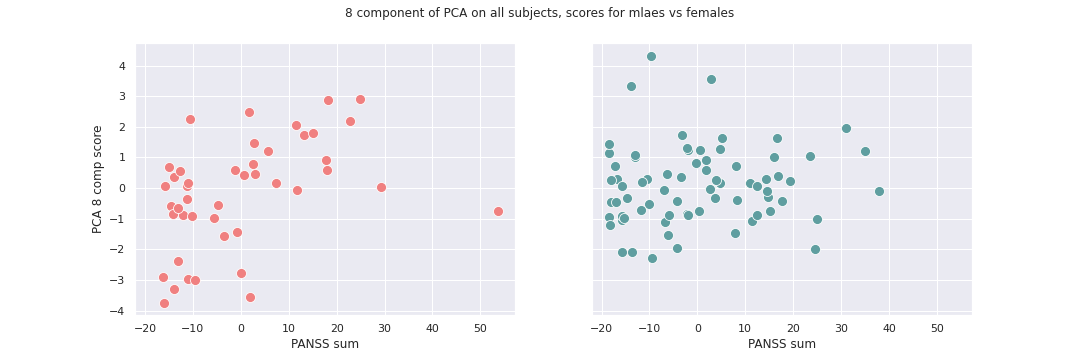

In [140]:
fig,ax = plt.subplots(1,2, figsize=(15,5), sharex=True, sharey=True)
sns.scatterplot(v2_ccontrol[f_id,0],v1_scores[f_id,8], color = 'lightcoral', ax=ax[0], s=100)
ax[0].set_xlabel('PANSS sum')
ax[0].set_ylabel('PCA 8 comp score')
sns.scatterplot(v2_ccontrol[m_id,0],v1_scores[m_id,8], color = 'cadetblue', ax = ax[1], s=100)
ax[1].set_xlabel('PANSS sum')
ax[1].set_ylabel('PCA 8 comp score')
fig.suptitle('8 component of PCA on all subjects, scores for mlaes vs females')
plt.savefig(os.path.join(images_dir, 'scatter_PCA8_PANSS'))

In [117]:
v2_ccontrol

array([[-9.68837790e+00, -1.94952252e+00, -4.26087871e+00,
        -3.47797667e+00,  1.71089517e+01],
       [-1.06039027e+01, -1.82591789e+00, -1.69541119e+00,
        -7.08257361e+00,  1.23571484e+01],
       [ 1.68688113e+01,  1.59641036e+01, -2.51579106e+00,
         3.42049870e+00, -3.45960551e+01],
       [-8.95000162e-01,  1.42735703e+00, -1.48885842e+00,
        -8.33498778e-01,  6.60726794e+00],
       [-3.37302713e+00, -2.76502229e+00,  1.70511432e+00,
        -2.31311916e+00,  1.36019580e+01],
       [-1.20686515e+01, -1.99196217e+00, -2.83082494e+00,
        -7.24586436e+00,  6.84876185e+00],
       [ 2.49570489e+01,  5.01722000e+00,  8.17666338e+00,
         1.17631655e+01, -8.17842414e+00],
       [-2.18027418e+00, -2.69615600e+00,  7.61276706e-01,
        -2.45394885e-01,  3.39806297e+00],
       [ 1.31858635e+01, -1.61558471e+00,  7.66059346e+00,
         7.14085472e+00, -1.83048558e+01],
       [-1.01006033e+01, -1.64610035e+00, -5.54876496e+00,
        -2.90573800e+00

In [112]:
from scipy import stats
stats.spearmanr(v2_ccontrol[:,0],v1_scores[:,8])

SpearmanrResult(correlation=0.291930957598124, pvalue=0.0014742524987208317)

/home/barbora/Instalacky/yes/envs/PCN/lib/python3.9/site-packages/nilearn/plotting/html_document.py:56: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '


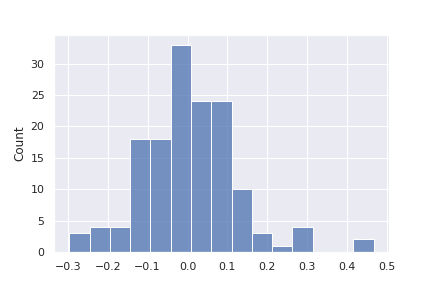

In [63]:
sns.histplot(loadings_thick[:,8])

id = np.where(abs(loadings_thick[:,8])>0.2)[0]
scores_names = [idp_ids[i] for i in id]

to_plot = pd.DataFrame(np.arange(1,len(scores_names)+1)[:,np.newaxis], index=scores_names, columns=['stlpcek'])

r_data_mapping, r_view = custom.prepare_destrieux_plotting(to_plot, 'r', method='counts')
l_data_mapping, l_view = custom.prepare_destrieux_plotting(to_plot, 'l', method='counts')


In [64]:
r_view

In [65]:
l_view

In [54]:
import pingouin as pg
pk = pg.linear_regression(v1_pat[scores_names+['age']], v1_pat[clin_id[-1]])

In [55]:
pk

names       coef        se         T  \
0                          Intercept  62.246688  6.325022  9.841340   
1              lh_G_cuneus_thickness   2.121889  2.309677  0.918695   
2          lh_G_precentral_thickness  -3.150403  2.404909 -1.309989   
3        lh_Pole_occipital_thickness  -0.718175  2.148194 -0.334316   
4           lh_S_calcarine_thickness  -1.276604  2.131737 -0.598856   
5              rh_G_cuneus_thickness  -1.234019  2.439971 -0.505752   
6   rh_G_Ins_lg&S_cent_ins_thickness  -0.624219  1.416474 -0.440685   
7          rh_G_precentral_thickness   4.935236  2.481430  1.988867   
8        rh_Pole_occipital_thickness  -2.331145  3.122895 -0.746469   
9   rh_S_collat_transv_ant_thickness  -0.055984  1.418718 -0.039461   
10       rh_S_pericallosal_thickness  -1.618608  1.334145 -1.213218   
11                               age   0.232682  0.212637  1.094269   

            pval        r2    adj_r2   CI[2.5%]  CI[97.5%]  
0   1.522808e-16  0.099647  0.004417  49.703932  74.789444  
1   3.603809e-01  0.099647  0.004417  -2.458288   6.702066  
2   1.930858e-01  0.099647  0.004417  -7.919427   1.618621  
3   7.388145e-01  0.099647  0.004417  -4.978126   3.541775  
4   5.505709e-01  0.099647  0.004417  -5.503919   2.950710  
5   6.141013e-01  0.099647  0.004417  -6.072574   3.604535  
6   6.603557e-01  0.099647  0.004417  -3.433141   2.184703  
7   4.934252e-02  0.099647  0.004417   0.014466   9.856006  
8   4.570682e-01  0.099647  0.004417  -8.523962   3.861673  
9   9.685985e-01  0.099647  0.004417  -2.869354   2.757386  
10  2.277950e-01  0.099647  0.004417  -4.264266   1.027051  
11  2.763651e-01  0.099647  0.004417  -0.188985   0.654349

**Investigation of the weird blue columns in females**
------------------------------------------------------------

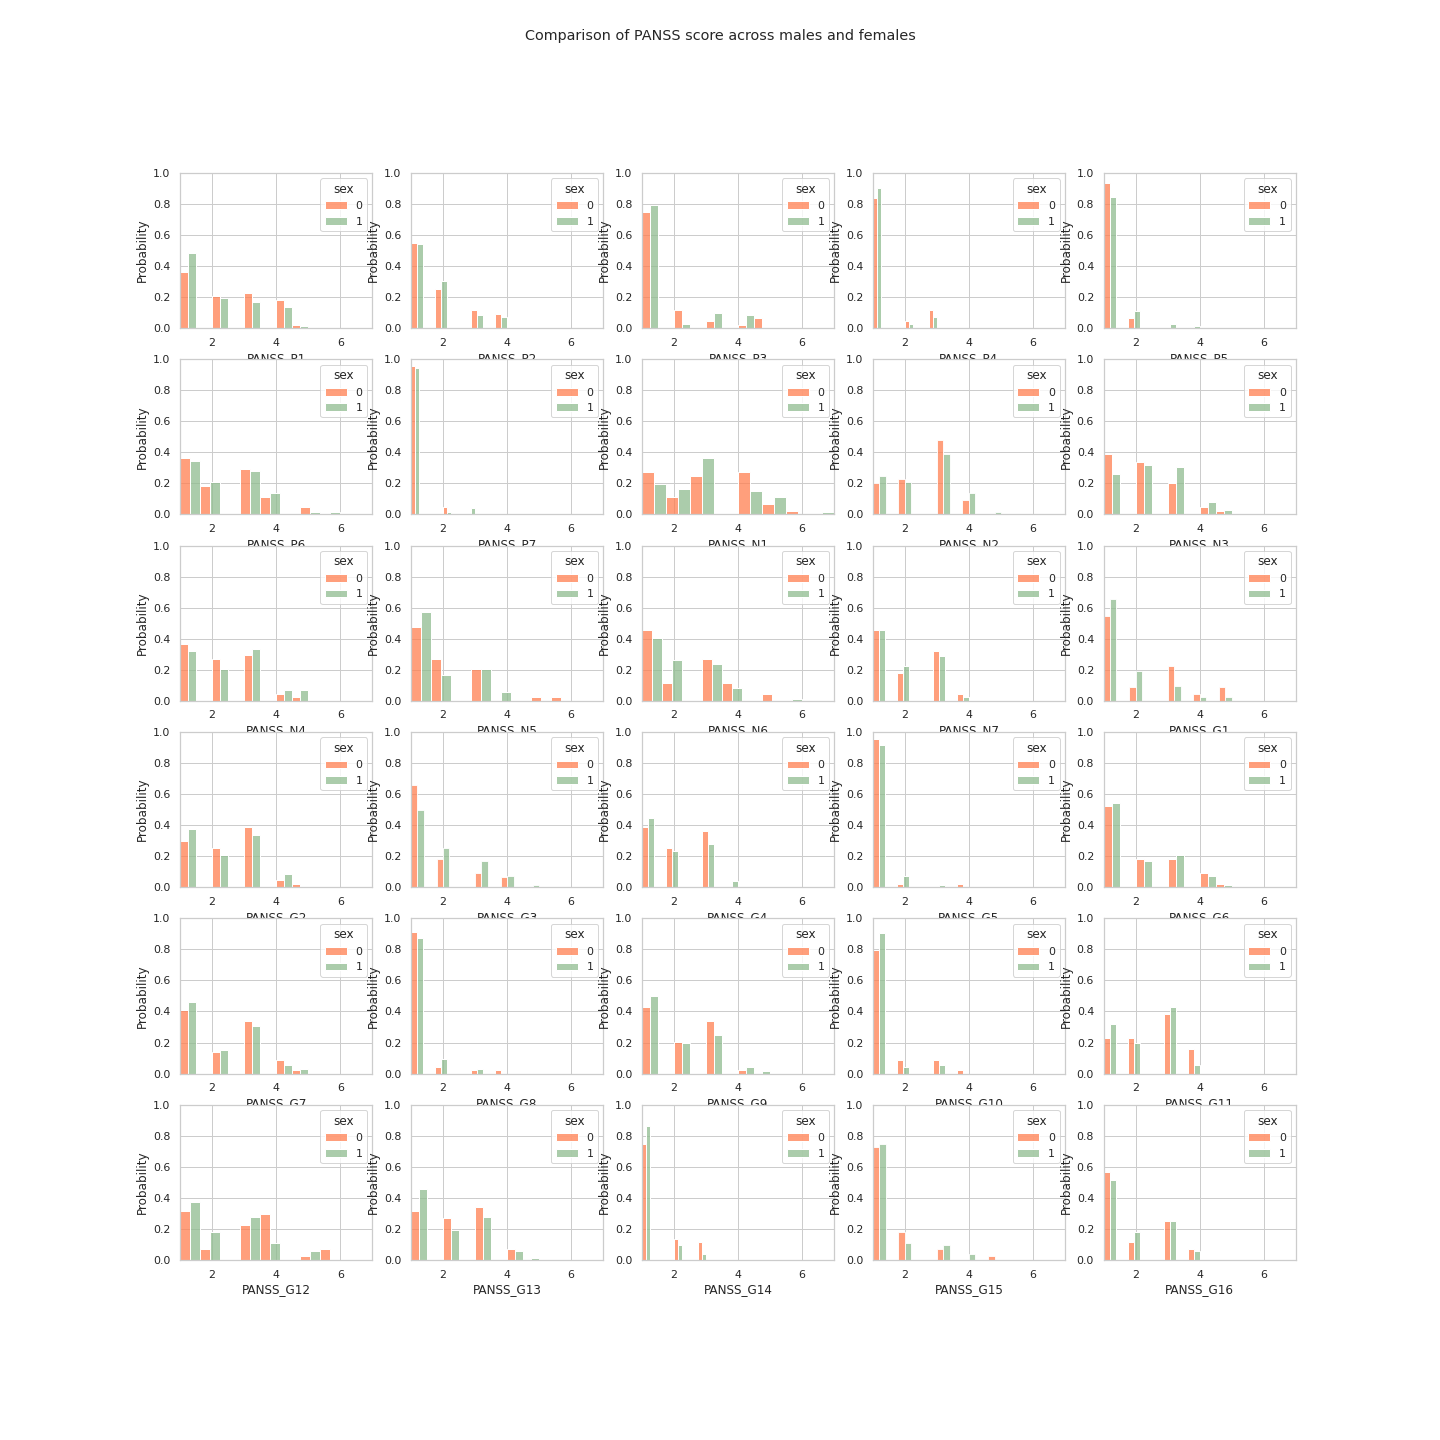

In [26]:
# PANSS across sex
FM_colors = ["coral", "darkseagreen"]
fm_palette = sns.set_palette(sns.color_palette(FM_colors))

fig, ax = plt.subplots(6,5, figsize=(20,20))

for iplot in range(30):    
    x = int(np.floor(iplot/5))
    y = np.mod(iplot,5)
    sns.histplot(ax = ax[x,y], data = v1_pat, x = clin_id[iplot], hue='sex', stat='probability', common_norm = False, multiple='dodge', palette=fm_palette)
    ax[x,y].set_xlim(1,7)
    ax[x,y].set_ylim(0,1)

fig.suptitle('Comparison of PANSS score across males and females')
plt.savefig(os.path.join(images_dir, 'PANSS_across_sex'),  bbox_inches='tight')
    

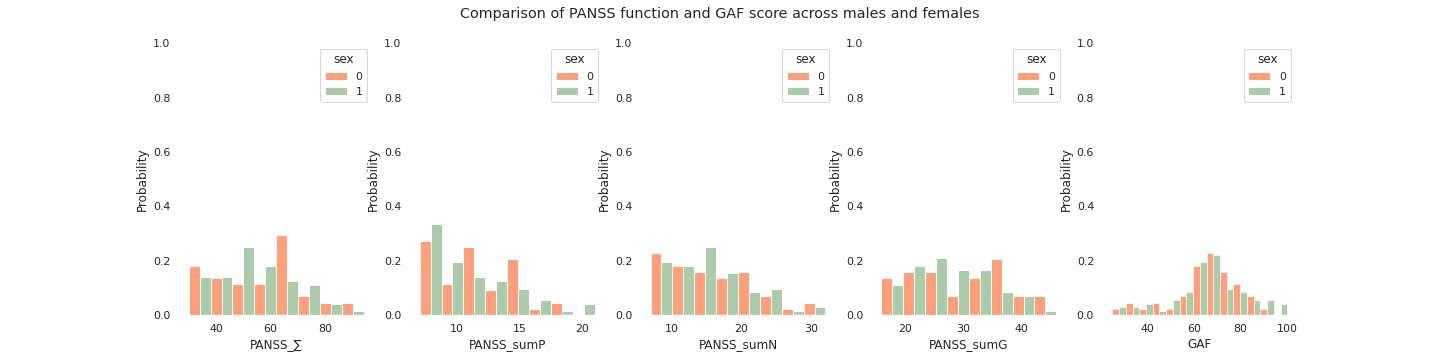

In [300]:
# PANSS across sex
FM_colors = ["coral", "darkseagreen"]
fm_palette = sns.set_palette(sns.color_palette(FM_colors))

fig, ax = plt.subplots(1,5, figsize=(20,5))

for iplot in range(len(clin_id_small)):    
    #x = int(np.floor(iplot/5))
    #y = np.mod(iplot,5)
    sns.histplot(ax = ax[iplot], data = v1_pat, x = clin_id_small[iplot], hue='sex', stat='probability', common_norm = False, multiple='dodge', palette=fm_palette)
    #ax[x,y].set_xlim(1,7)
    ax[iplot].set_ylim(0,1)

fig.suptitle('Comparison of PANSS function and GAF score across males and females')
plt.savefig(os.path.join(images_dir, 'PANSS_GAF_across_sex'),  bbox_inches='tight')

# Run Mann Whitney U test
for iclin in range(len(clin_id_small)):
    print(stats.mannwhitneyu(v1_pat[v1_pat["sex"]==0][clin_id_small[iclin]],v1_pat[v1_pat["sex"]==1][clin_id_small[iclin]]))

print(images_dir)
    

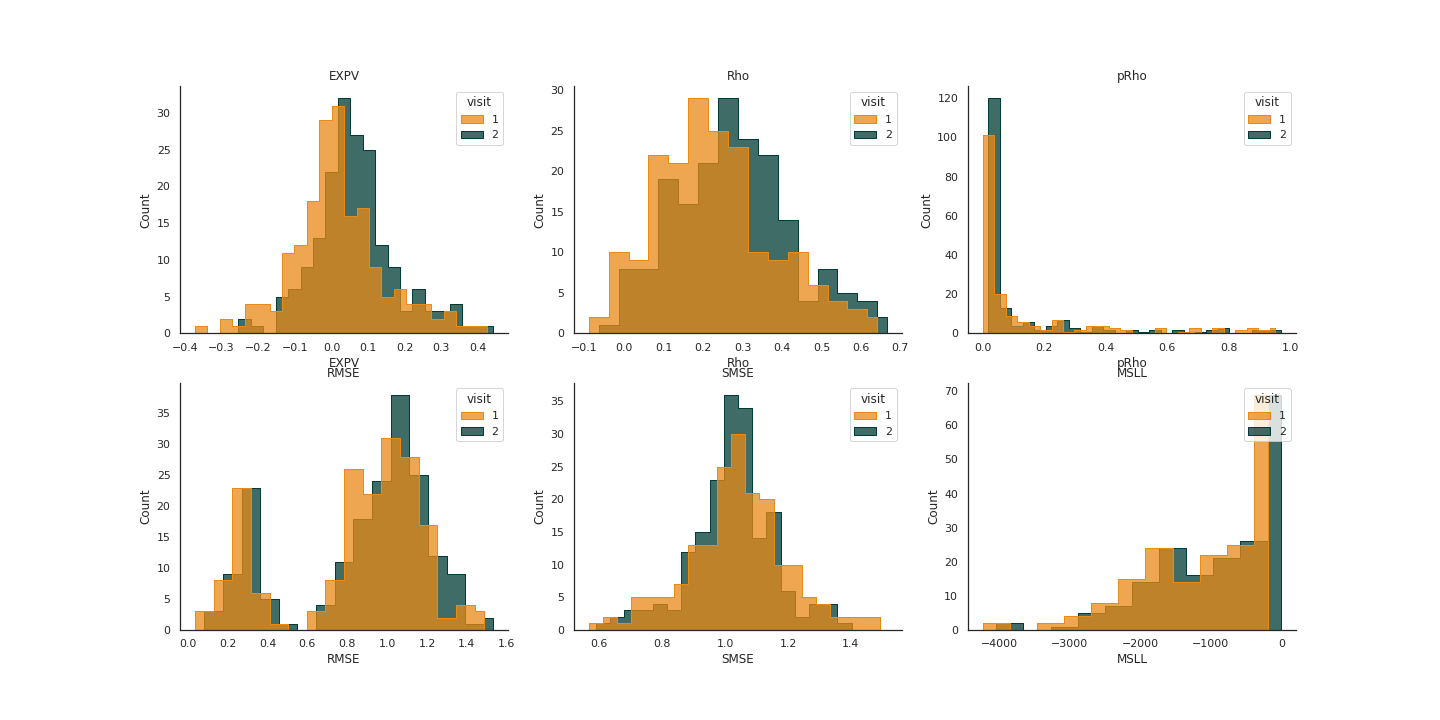

In [62]:
# Concatenate and plot quality measures of fitted models
v1_qm,quality_measures = idp_concat_quality('/home/barbora/Documents/Projects/Normative_Models/ESO/models/pretrained_long/V1', idp_ids)
v1_qm['visit'] = '1'
v2_qm,quality_measures = idp_concat_quality('/home/barbora/Documents/Projects/Normative_Models/ESO/models/pretrained_long/V2', idp_ids)
v2_qm['visit'] = '2'

qm = pd.concat([v1_qm, v2_qm]).reset_index()

visit_colors = ["#E98A15", "#003B36"]


sns.set_style("white")
fig, ax = plt.subplots(2,3, figsize=(20,10))

for iplot in range(6):
    x = int(np.floor(iplot/3))
    y = np.mod(iplot,3)
    sns.histplot(data = qm, x=quality_measures[iplot], hue='visit', element='step', ax=ax[x,y], palette=sns.color_palette(visit_colors), multiple='dodge')
    ax[x,y].set_title(quality_measures[iplot])

sns.despine()
plt.savefig(os.path.join('/home/barbora/Documents/Projects/Normative_Models/ESO/models/pretrained_long', 'quality_measures'),  bbox_inches='tight')

**Finding alternative for the correlations**
--------------------------------------------

In [240]:
PANSS_ren = {1:1, 2:2, 3:2, 4:2, 5:2, 6:2, 7:2}

resm = np.empty([len(idp_ids), len(clin_id[0:30])])
resf = np.empty([len(idp_ids), len(clin_id[0:30])])
sex = 1

for iroi, roi in enumerate(idp_ids):
    for iclin, clin in enumerate(clin_id[0:30]):
        #print(str(iroi)+','+str(iclin))
        x, resm[iroi, iclin] = kruskal_wallis(v1_pat[v1_pat["sex"]==1][roi], v1_pat[v1_pat["sex"]==1][clin].replace(PANSS_ren))
        x, resf[iroi, iclin] = kruskal_wallis(v1_pat[v1_pat["sex"]==0][roi], v1_pat[v1_pat["sex"]==0][clin].replace(PANSS_ren))

<AxesSubplot:>

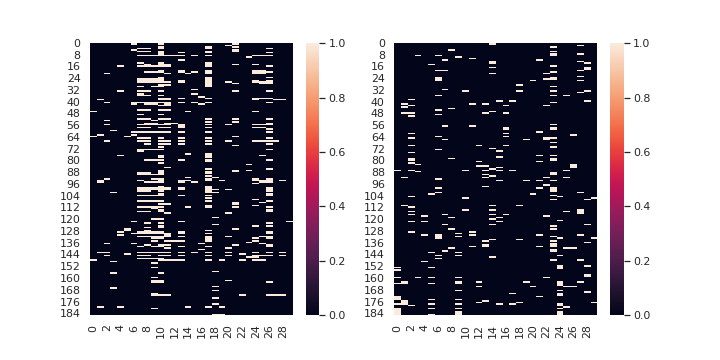

In [241]:
fig,ax = plt.subplots(1,2, figsize=(10,5))
sns.heatmap(resf<0.05, ax=ax[0])
sns.heatmap(resm<0.05, ax=ax[1])

In [203]:
def kruskal_wallis(vec, group):
    import scipy.stats as stats

    group = group.astype("category")
    group_names=group.unique()

    if (group.nunique()==0) | (group.nunique()==1):
        print('not valid group vector')

    elif group.nunique()==2:
        #print('only two groups present, running man whitney U')
        u,p = stats.mannwhitneyu(vec[group==group_names[0]], vec[group==group_names[1]], method="exact")

    elif group.nunique()==3:
        u,p = stats.kruskal(vec[group==group_names[0]],
                            vec[group==group_names[1]],
                            vec[group==group_names[2]])

    elif group.nunique()==4:
        u,p = stats.kruskal(vec[group==group_names[0]],
                            vec[group==group_names[1]],
                            vec[group==group_names[2]],
                            vec[group==group_names[3]])

    elif group.nunique()==5:
        u,p = stats.kruskal(vec[group==group_names[0]],
                            vec[group==group_names[1]],
                            vec[group==group_names[2]],
                            vec[group==group_names[3]],
                            vec[group==group_names[4]])

    elif group.nunique()==6:
        u,p = stats.kruskal(vec[group==group_names[0]],
                            vec[group==group_names[1]],
                            vec[group==group_names[2]],
                            vec[group==group_names[3]],
                            vec[group==group_names[4]],
                            vec[group==group_names[5]])                

    elif group.nunique()==7:
        u,p = stats.kruskal(vec[group==group_names[0]],
                            vec[group==group_names[1]],
                            vec[group==group_names[2]],
                            vec[group==group_names[3]],
                            vec[group==group_names[4]],
                            vec[group==group_names[5]],
                            vec[group==group_names[6]])       
    return(u,p)                                 

In [ ]:
# Plot subcortical structures 
data_short, data_mapped = fs_map_subcortical(pd.DataFrame(df_spearman_r['v2-v1_PANSS_sum_all']))
enigmatoolbox.plotting.surface_plotting.plot_subcortical(pk, size=(800,400), 
                                                        cmap='RdBu_r', color_bar=True,
                                                        color_range=(-0.5,0.5))